<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %pip install -U tf_keras pandas scipy tqdm scikit-learn matplotlib

Once the celd finished click on restart sesion.

In [2]:
output_dir = 'results'
run_date = '2024-dec-15'
layer = 14

!mkdir {output_dir}
!mkdir {output_dir}/{run_date}
!mkdir {output_dir}/{run_date}/layer{layer}
output_dir = f'{output_dir}/{run_date}/layer{layer}'

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
mkdir: cannot create directory 'results': File exists
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
mkdir: cannot create directory 'results/2024-dec-15': File exists
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
mkdir: cannot create directory 'results/2024-dec-15/layer14': File exists


# Download sources

In [3]:
# %rm -rf experiments
# %rm -rf src
# %rm -rf lhcb-rich-gan-uncertainty-conare/
# !git clone https://gitlab.com/evillag/lhcb-rich-gan-uncertainty-conare.git
# !mv lhcb-rich-gan-uncertainty-conare/experiments .
# !mv lhcb-rich-gan-uncertainty-conare/src .
# %rm -rf lhcb-rich-gan-uncertainty-conare/
# %rm -rf sample_data/

In [4]:
# dataset downloading and extraction
# !wget --show-progress -O rich.zip https://www.dropbox.com/scl/fi/vy885v97hvgirtwtbk8r6/rich.zip?rlkey=zwg284rv7q0lrr9z1pk88g5yx&st=1s4wciep&dl=0
# !unzip -qq rich.zip
# !rm rich.zip

# # checkpoints2
# !wget --show-progress -O checkpoints.zip https://www.dropbox.com/scl/fi/466pwb9aoizlxdrcwmu2p/checkpoints_dropout_0.01.zip?rlkey=eqx2c82md4qber0nilii3drq4&st=6m5qqjgg&dl=0
# !unzip -qq checkpoints.zip
# !rm checkpoints.zip
# 
# # embeddings
# !wget --show-progress -O embeddings.zip https://www.dropbox.com/scl/fi/qjwk4u5i55603zwubqbjw/embeddings.zip?rlkey=7ucyd46sa11nplaen0qz47cd4&st=8upo51x9&dl=0
# !unzip -qq embeddings.zip
# !rm embeddings.zip


# Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model
from feature_densities.feature_density_evaluator import create_embeddings_model
from feature_densities.feature_density_evaluator import get_histogram
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model
from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel
from tqdm import trange


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Instruct tf to use the GPU memory efficiently
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

print(f'GPU available? {tf.config.list_physical_devices("GPU")}')

2024-12-15 12:41:45.644563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734288105.755932     962 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734288105.788792     962 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 12:41:46.083352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

## Experiment Params

In [6]:
# Parameters
PARTICLE = 'pion'
MCD_DP = 0.1
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'data/rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLK', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# Experiment repetitions
N = 30

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load previous results (Optional)

Uncomment to load previous execution results.

In [7]:
# output_dir = f'/content/drive/MyDrive/cern/data/results/'

# x_sample = np.load(output_dir + f'{PARTICLE}_x_real.npy')
# y_sample = np.load(output_dir + f'{PARTICLE}_y_real.npy')
# t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

# mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
# fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
# #fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [8]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	data/rich/pion2_+_down_2016_.csv
	data/rich/pion2_+_up_2016_.csv
	data/rich/pion2_-_down_2016_.csv
	data/rich/pion2_-_up_2016_.csv
	data/rich/pion_+_down_2016_.csv
	data/rich/pion_+_up_2016_.csv
	data/rich/pion_-_down_2016_.csv
	data/rich/pion_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 3.166079521179199
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948325, 3)
targets_train shape	(948325, 5)
feats_val shape  	(527302, 3)
targets_val shape	(527302, 5)
feats_train_orig shape	(948325, 3)
targets_train_orig shape	(948325, 5)
feats_val_orig shape  	(527302, 3)
targets_val_orig shape	(527302, 5)



In [9]:
# Draw a sample of the datasets
x_sample, y_sample, x_sample_orig, y_sample_orig = subsample_dataset(dataset['feats_val'], dataset['targets_val'], dataset['feats_val_orig'],  dataset['targets_val_orig'] , SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape,  x_sample_orig.shape, y_sample_orig.shape

I0000 00:00:1734288134.880202     962 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2e:00.0, compute capability: 8.9


(TensorShape([100000, 3]),
 TensorShape([100000, 5]),
 TensorShape([100000, 3]),
 TensorShape([100000, 5]))

# Model creation

In [10]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=MCD_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.1
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0_Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0_LeakyReLU (LeakyReLU)             (None, 128)                           0    

## Single model prediction

In [11]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

I0000 00:00:1734288136.087607    1448 cuda_dnn.cc:529] Loaded cuDNN version 90300


3125/3125 [==============================] - 9s 3ms/step


(100000, 5)

In [12]:
# Save real and generated targets
np.save(f'{output_dir}/{PARTICLE}_x_real.npy', x_sample)
np.save(f'{output_dir}/{PARTICLE}_y_real.npy', y_sample)
np.save(f'{output_dir}/{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

/tmp/ipykernel_962/3963364024.py:14: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
/tmp/ipykernel_962/3963364024.py:15: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')


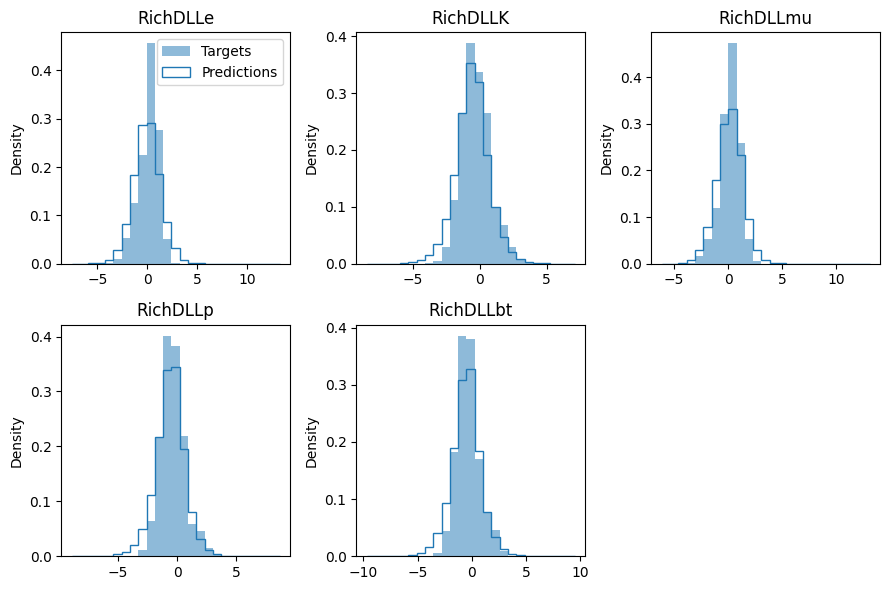

In [13]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

In [14]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress, kstest

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None, bin_type = 'quantiles',
                                                 particle_index = 0, metric = 'JS', n_rows = 2, n_cols = 5, dll_columns=DLL_COLUMNS):
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  if bin_type == 'linear':
    bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
  else: # Quantiles
    bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, n_bins + 1))

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 3)

  distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_title(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}')
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{dll_columns[particle_index]}')


    if metric == 'JS':
      dist = jensenshannon(predictions_hist, targets_hist)
    else:
      dist = kstest(predictions[indices], targets[indices]).statistic

    distances += [dist]
    print(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_uncertainty_score_bins_for_{dll_columns[particle_index]}.tex')
  except:
    plt.show()
  print(f"{metric} Distances:\n" + ", ".join([str(dist) for dist in distances]))

  return bin_edges, distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  bin_ranges = np.mean([bin_ranges[1:], bin_ranges[:-1]], 0)

  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges, distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges, distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0, metric='JS'):
  plt.figure()
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  correlation_coefficient = []
  for i in range(5):
    bin_ranges = np.mean([all_bin_ranges[i][1:], all_bin_ranges[i][:-1]], 0)
    plt.plot(bin_ranges, all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(bin_ranges, all_distances[i])
    correlation_coefficient += [regress.rvalue]
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  if metric == 'JS':
    plt.ylabel('Jensen–Shannon distance')
  else:
    plt.ylabel('Kolmogorov-Smirnov distance')
  plt.legend()

  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_reliability_curves_{metric}.tex')
  except:
    plt.show()


## Feature Densities method

### Generation of FD embeddings

In [15]:
print('Generating an embeddings model')
embeddings_model = create_embeddings_model(model, layer)

embeddings_list = []

for _ in trange(5):
    train_embeddings, _ = embeddings_model.predict(dataset['feats_train'])
    # test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])
    embeddings_list.append(train_embeddings)

stacked_train_embeddings = np.stack(embeddings_list, axis=0)
train_embeddings = np.mean(stacked_train_embeddings, axis=0)
train_embeddings_std = np.std(stacked_train_embeddings, axis=0)

!mkdir embeddings
np.save(embeddings_dir + f'{PARTICLE}_layer{layer}_train_embeddings_all.npy', embeddings_list)
np.save(embeddings_dir + f'{PARTICLE}_layer{layer}_train_embeddings.npy', train_embeddings)
np.save(embeddings_dir + f'{PARTICLE}_layer{layer}_train_embeddings_std.npy', train_embeddings)

Generating an embeddings model


  0%|          | 0/5 [00:00<?, ?it/s]

29636/29636 [==============================] - 100s 3ms/step


 20%|██        | 1/5 [02:02<08:09, 122.39s/it]

29636/29636 [==============================] - 100s 3ms/step


 40%|████      | 2/5 [03:57<05:54, 118.04s/it]

29636/29636 [==============================] - 95s 3ms/step


 60%|██████    | 3/5 [05:45<03:47, 113.59s/it]

29636/29636 [==============================] - 97s 3ms/step


 80%|████████  | 4/5 [07:38<01:53, 113.10s/it]

29636/29636 [==============================] - 92s 3ms/step


100%|██████████| 5/5 [09:27<00:00, 113.43s/it]


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
mkdir: cannot create directory 'embeddings': File exists


### Uncertainty estimation

In [16]:
train_embeddings

array([[-0.03754584,  0.20696971,  0.11066809, ..., -0.86920434,
        -0.70138365, -0.46403727],
       [ 0.09848817,  0.02152159,  0.07100284, ..., -0.2143381 ,
        -0.37858582, -0.76501095],
       [-0.05328405,  0.24758378,  0.20919457, ..., -0.6977426 ,
        -0.2685086 , -0.9978323 ],
       ...,
       [-0.0727971 ,  0.25502458,  0.24403536, ..., -0.7655751 ,
        -0.43992704, -0.58844614],
       [-0.7274588 ,  0.10425603,  0.12031867, ..., -1.1952487 ,
        -0.43708748, -0.4456737 ],
       [-0.49979466, -0.69260347,  0.00774962, ..., -0.39979142,
         0.20507224, -0.5953331 ]], dtype=float32)

In [17]:
train_embeddings.shape

(948325, 128)

In [18]:
print('Generating an embeddings model')
embeddings_model = create_embeddings_model(model, layer)

print('Generating histograms')
n_bins = 30
probs, hists = get_histogram(train_embeddings, n_bins)

Generating an embeddings model
Generating histograms


In [19]:
def fd_uncertainties_experiment(repetitions=N):

  fd_uncertainties = []
  fd_duration = []
  
  for _ in trange(repetitions):
    # Start the timer
    start_time = time.time()
    fd_unc, _ = fd_evaluate_model(embeddings_model, x_sample, probs, hists, n_bins, likelihood_method='histograms')
    fd_duration.append(time.time() - start_time)
    fd_uncertainties.append(fd_unc)
  
  stacked_fd = tf.stack(fd_uncertainties)
  average_fd = tf.reduce_mean(stacked_fd, axis=0)
  return average_fd, stacked_fd, fd_duration

def fd_global_experiment(global_repetitions=N):
  fd_all_uncertainties = []
  fd_all_durations = []

  for i in range(global_repetitions):
    print(f'FD Experiment Run {i + 1} of {N}')
    average_fd, _, fd_duration = fd_uncertainties_experiment()
    fd_all_uncertainties.append(average_fd)
    fd_all_durations.append(fd_duration)    

  return fd_all_uncertainties, fd_all_durations


In [20]:
fd_all_uncertainties, fd_all_durations = fd_global_experiment(1)

FD Experiment Run 1 of 30


100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


In [21]:
fd_avg_duration = np.mean(fd_all_durations)
fd_std_duration = np.std(fd_all_durations)

print(f"FD Average duration:\t{fd_avg_duration} seconds")
print(f"FD Std duration:\t\t{fd_std_duration} seconds")

# Save FD duration
np.save(f'{output_dir}/{PARTICLE}_fd_duration_list.npy', fd_all_durations)

# Save FD uncertainties
np.save(f'{output_dir}/{PARTICLE}_fd_uncertainty.npy', fd_all_uncertainties)

FD Average duration:	0.3038806438446045 seconds
FD Std duration:		0.048960989825202264 seconds


In [22]:
stacked_fd_uncertainty = tf.stack(fd_all_uncertainties)
fd_uncertainty_normalized = tf.reduce_mean(stacked_fd_uncertainty, axis=0)

print(f'Feature Densities using Averaged uncertainty score for x_sample:{fd_uncertainty_normalized.shape}')

# Save FD uncertainties normalized
np.save(f'{output_dir}/{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

Feature Densities using Averaged uncertainty score for x_sample:(100000,)


### Plot FD uncertainties

#### JS / Quantile bins

0.777 < unc. score < 0.836: Number of observations: 10000


/tmp/ipykernel_962/130207876.py:37: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
/tmp/ipykernel_962/130207876.py:38: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  predictions_hist = ax.hist(


0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


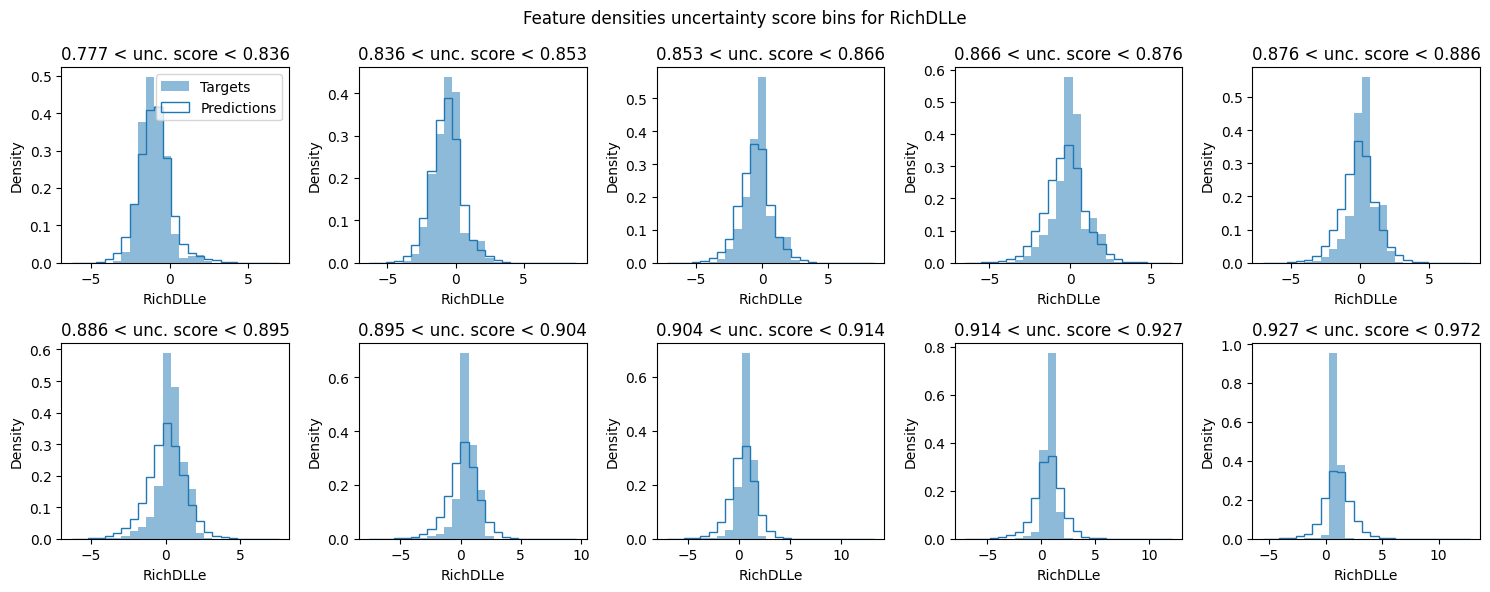

JS Distances:
0.12552686718718448, 0.11363019075420654, 0.15344513768687518, 0.18465673653758552, 0.20533811363366214, 0.2296890367990834, 0.26473157401788955, 0.29645976466770235, 0.33416009464997276, 0.4360580937287203
0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


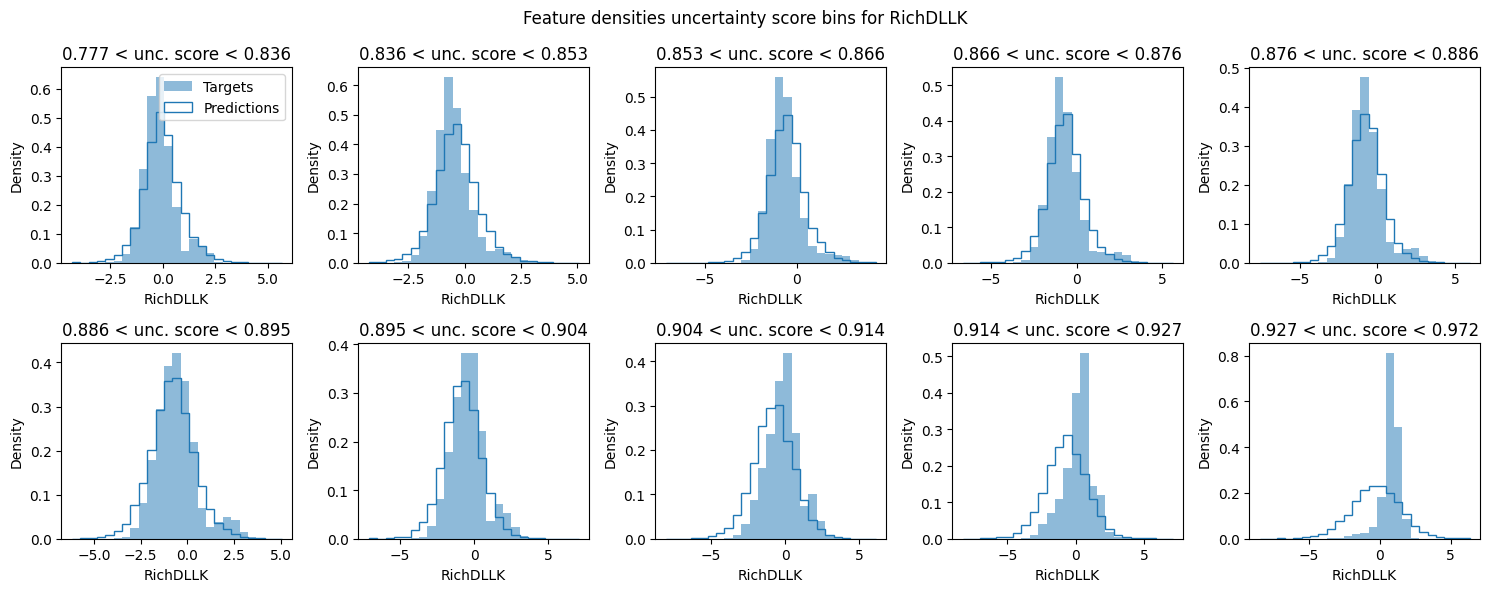

JS Distances:
0.1514372093192451, 0.14245784695849037, 0.14807090121737318, 0.1412315840677876, 0.13840491877959496, 0.14491570928627745, 0.169811699680419, 0.20692892816491207, 0.2929950144731062, 0.4560842626574894
0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


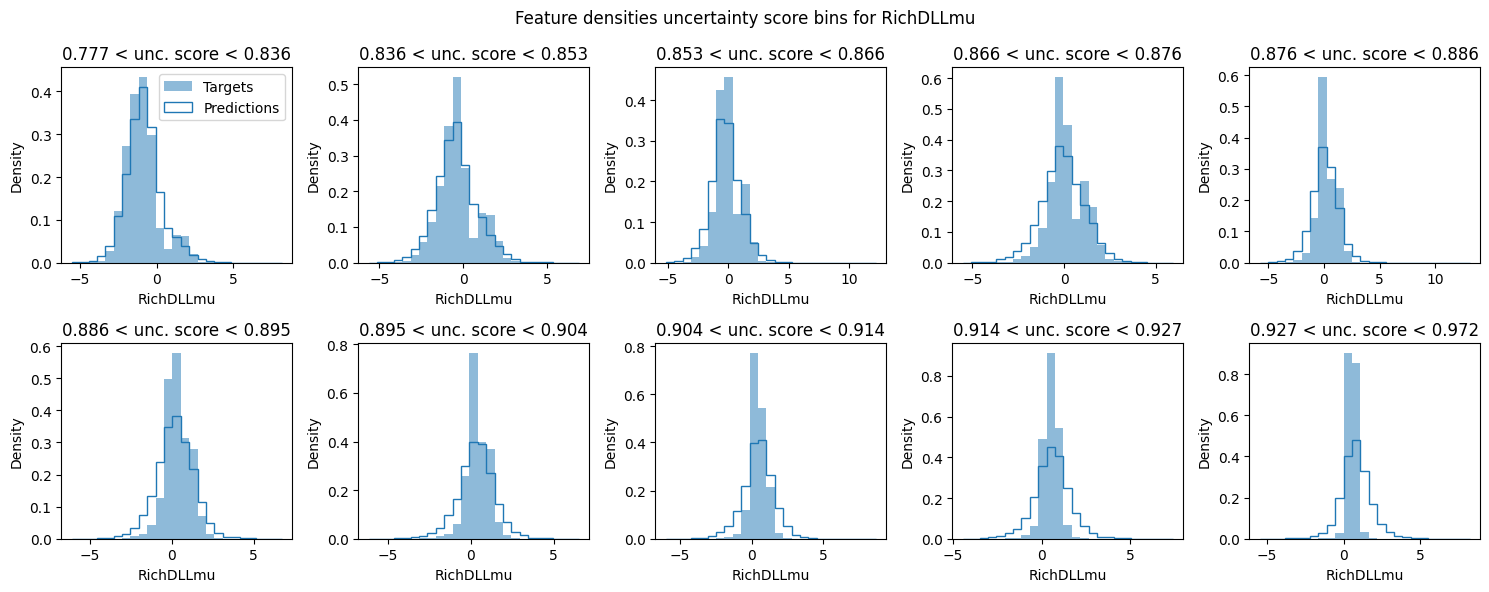

JS Distances:
0.11729823111203876, 0.1255881458422495, 0.15223043264454536, 0.1746115855456297, 0.18827876551163922, 0.19899781056229537, 0.23143229371204915, 0.27077290091002604, 0.31294054307807345, 0.4123583612389545
0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


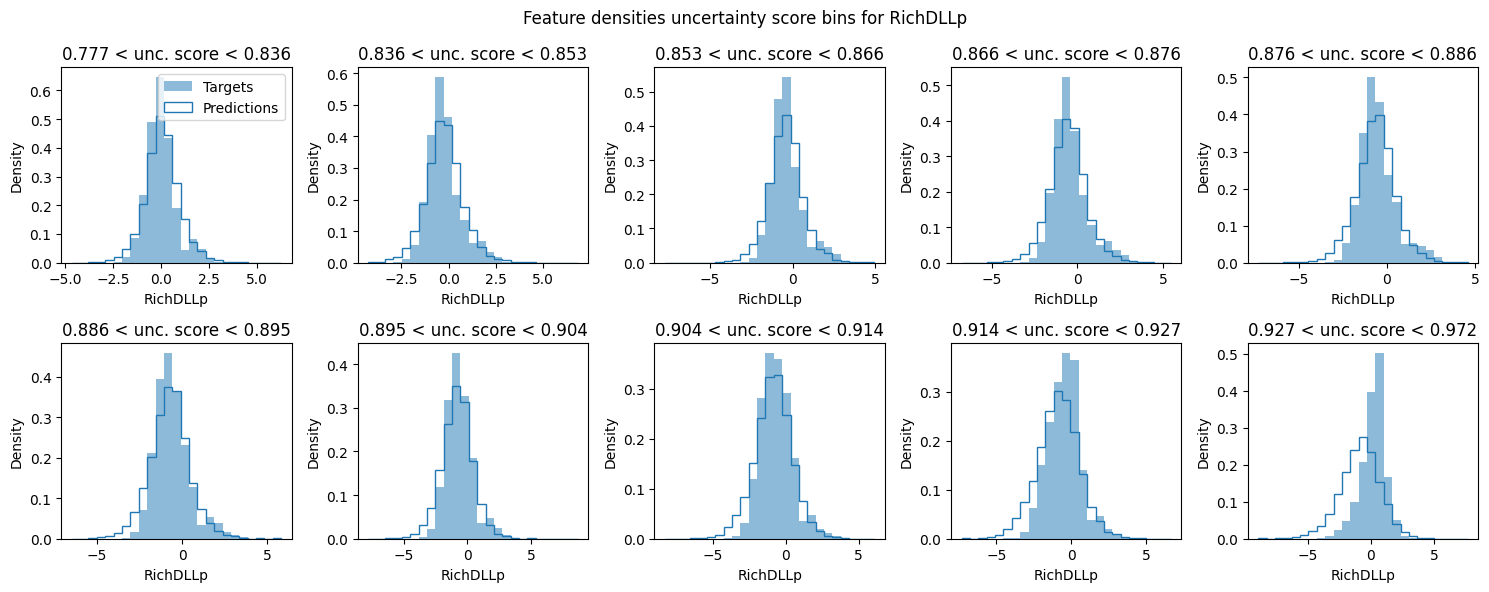

JS Distances:
0.14019722757350384, 0.13014064161068212, 0.14196873234953802, 0.14015934125430624, 0.14863689846435965, 0.14162103877573387, 0.14130417920123714, 0.14565096076648026, 0.17592395459280585, 0.3277686771197875
0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


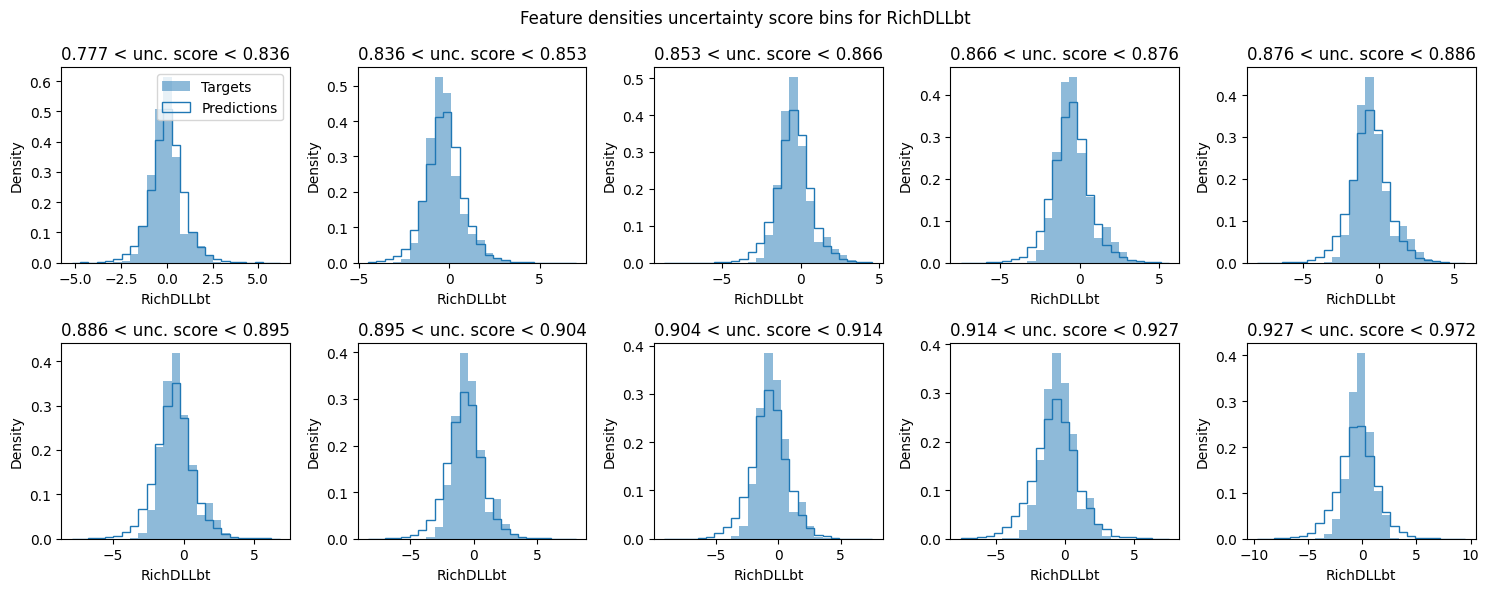

JS Distances:
0.13022747751920002, 0.11789663540154069, 0.13127290318890125, 0.1425719818050919, 0.15075509886885202, 0.15526202675430265, 0.16582443251145176, 0.17292086341385257, 0.1901130402100783, 0.22448092917160345


In [23]:
all_fd_bin_edges, all_fd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9405547522413424
Correlation coefficient for RichDLLK: 0.7421680124171839
Correlation coefficient for RichDLLmu: 0.9317342732042894
Correlation coefficient for RichDLLp: 0.6606030635269203
Correlation coefficient for RichDLLbt: 0.9104026993798465


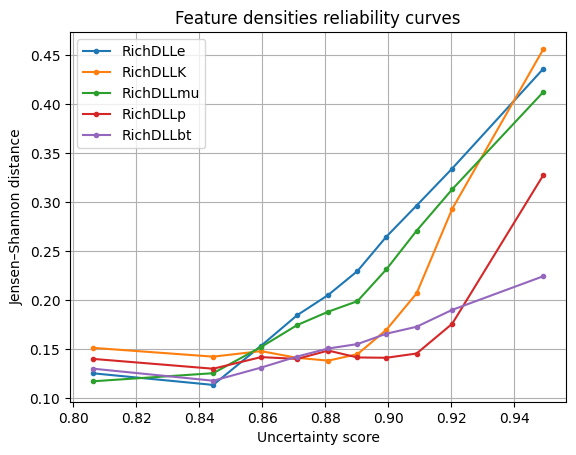

In [24]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

#### KS / Quantile bins

0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000


/tmp/ipykernel_962/130207876.py:37: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
/tmp/ipykernel_962/130207876.py:38: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  predictions_hist = ax.hist(


0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


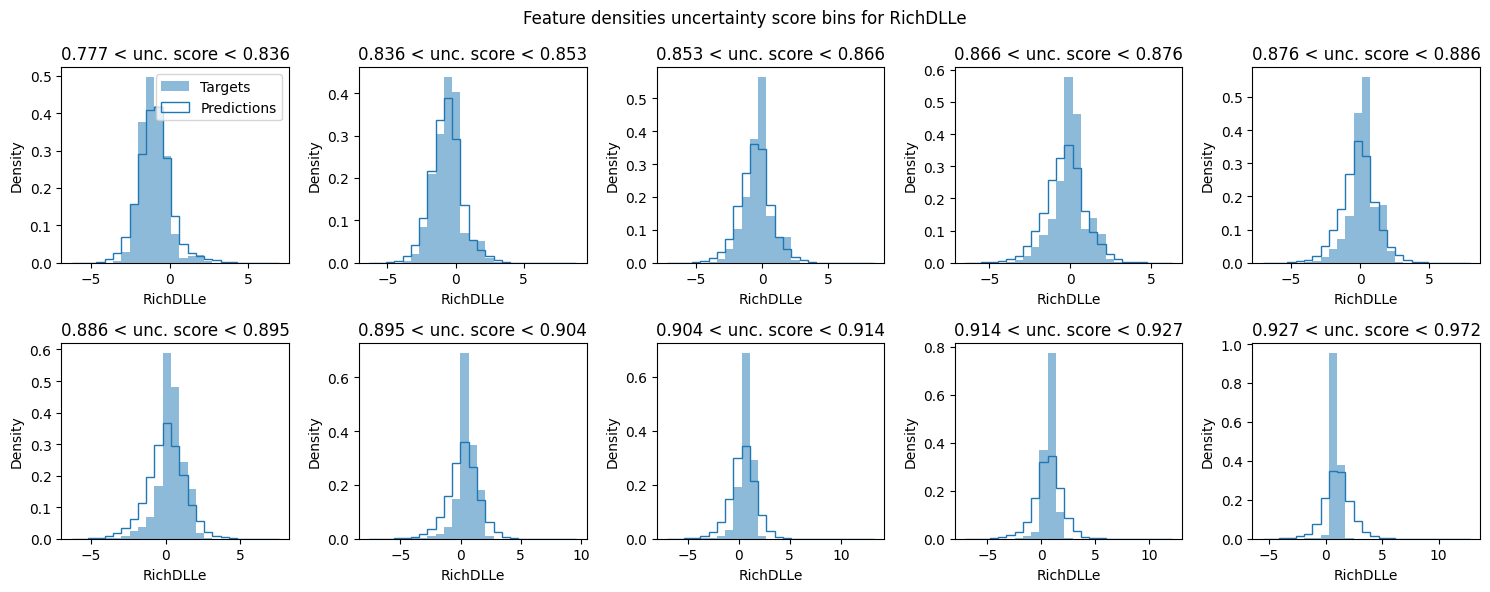

KS Distances:
0.0622, 0.0645, 0.1497, 0.1908, 0.2172, 0.2404, 0.2561, 0.2636, 0.2648, 0.35223522352235226
0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


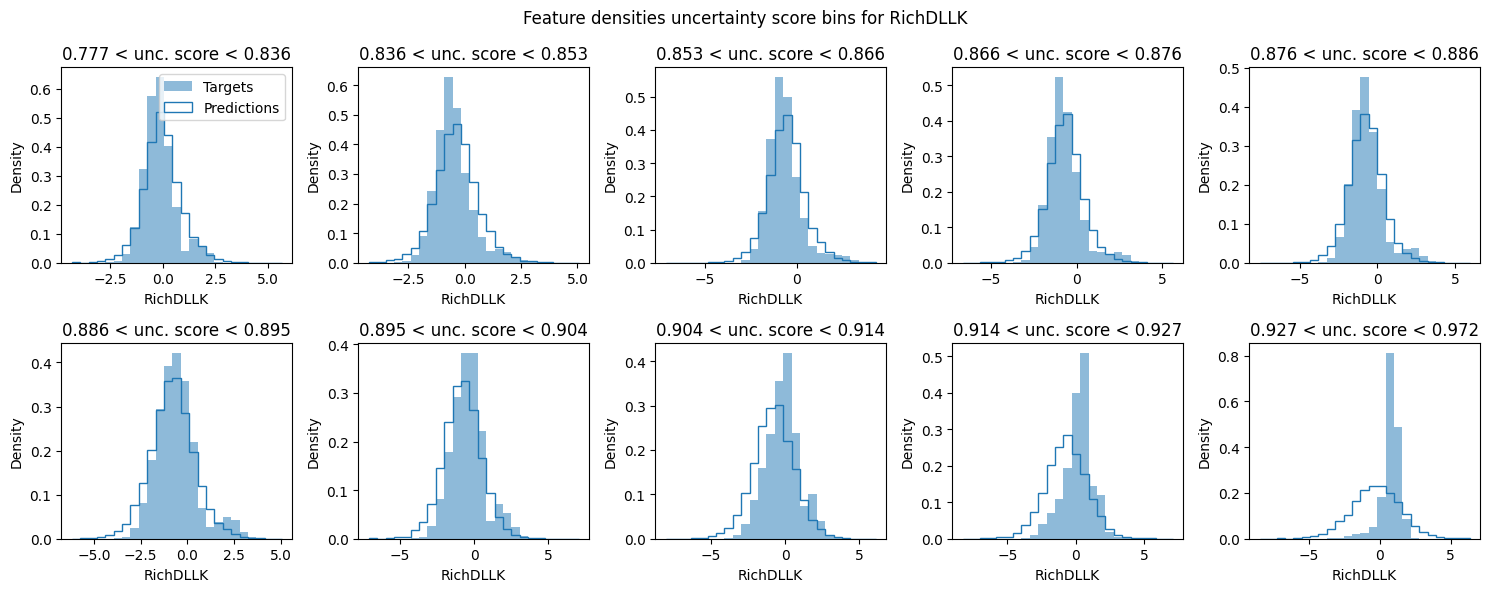

KS Distances:
0.1132, 0.1287, 0.1191, 0.0792, 0.0608, 0.0821, 0.1447, 0.2254, 0.3536, 0.49314931493149317
0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


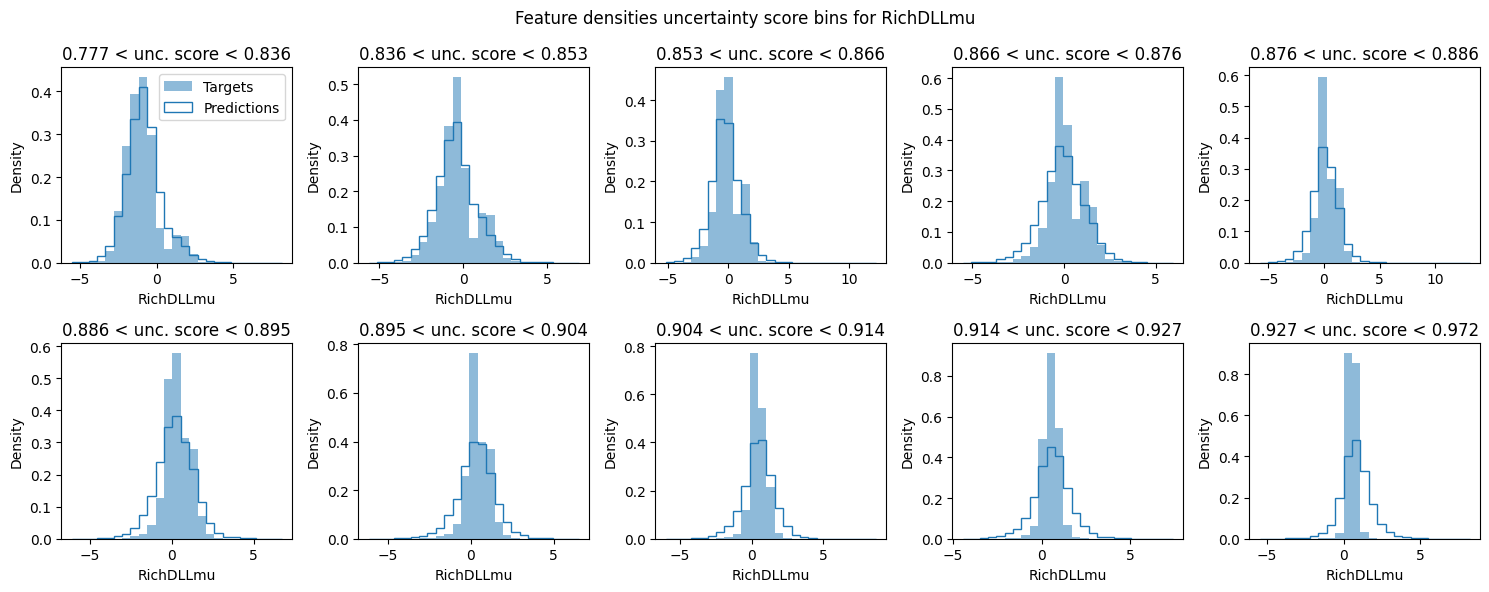

KS Distances:
0.0821, 0.0641, 0.1196, 0.1414, 0.1544, 0.1679, 0.1661, 0.1679, 0.2152, 0.3578357835783578
0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


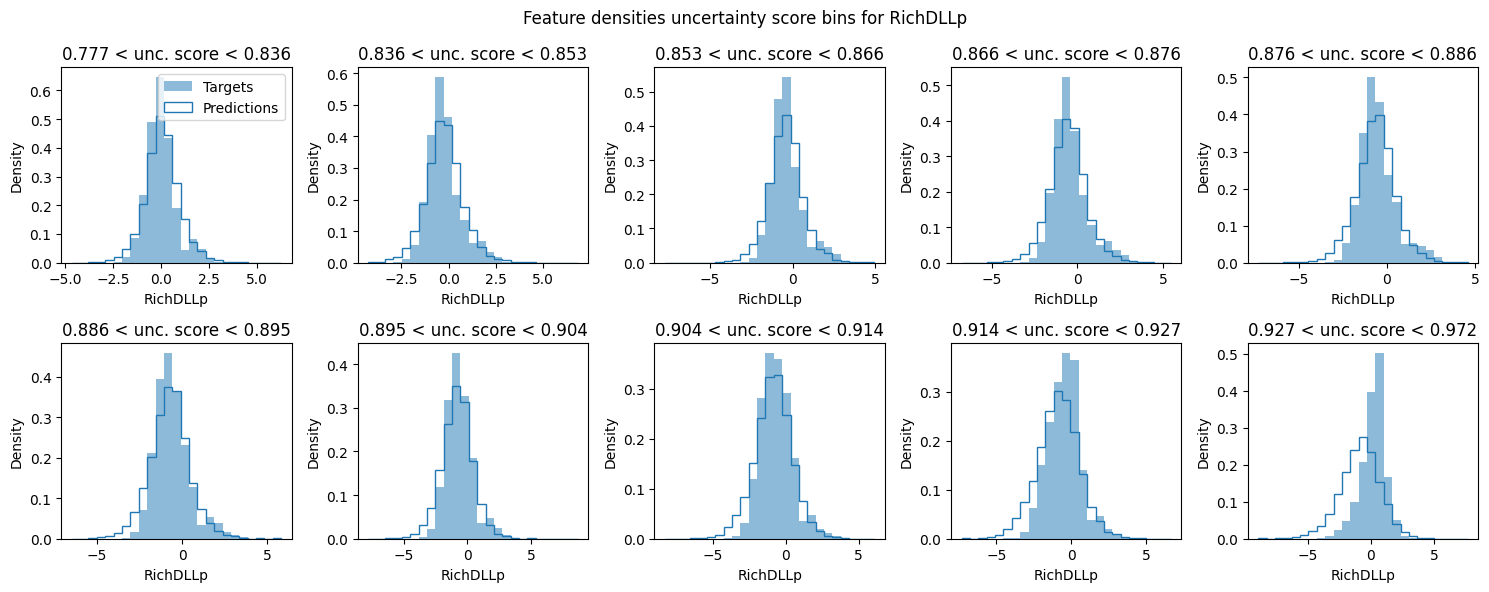

KS Distances:
0.0964, 0.0821, 0.0667, 0.0782, 0.0811, 0.0803, 0.0897, 0.0942, 0.1422, 0.38123812381238126
0.777 < unc. score < 0.836: Number of observations: 10000
0.836 < unc. score < 0.853: Number of observations: 10000
0.853 < unc. score < 0.866: Number of observations: 10000
0.866 < unc. score < 0.876: Number of observations: 10000
0.876 < unc. score < 0.886: Number of observations: 10000
0.886 < unc. score < 0.895: Number of observations: 10000
0.895 < unc. score < 0.904: Number of observations: 10000
0.904 < unc. score < 0.914: Number of observations: 10000
0.914 < unc. score < 0.927: Number of observations: 10000
0.927 < unc. score < 0.972: Number of observations: 9999


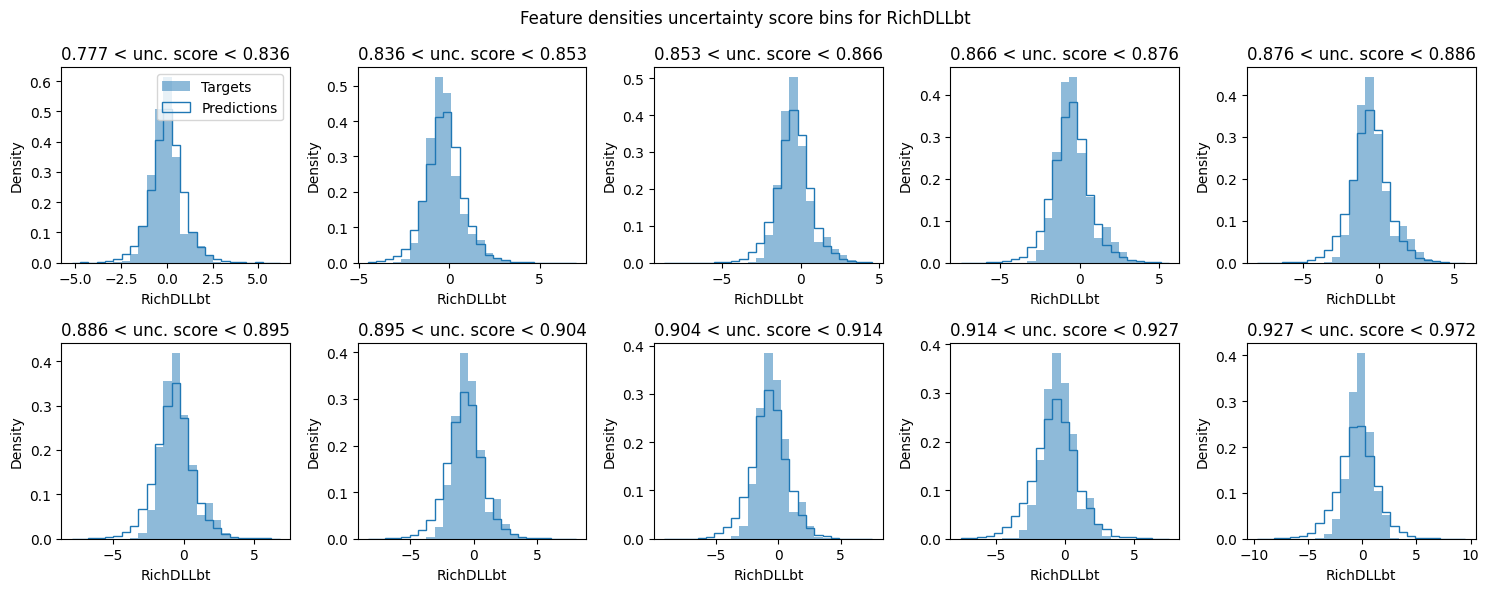

KS Distances:
0.0937, 0.0709, 0.0674, 0.084, 0.0932, 0.1114, 0.1201, 0.1185, 0.136, 0.16901690169016903


In [25]:
all_fd_bin_edges, all_fd_js_distances = [], []

# metric = 'JS'
metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9644356216300525
Correlation coefficient for RichDLLK: 0.7248093504056149
Correlation coefficient for RichDLLmu: 0.887506834603476
Correlation coefficient for RichDLLp: 0.6317829631849543
Correlation coefficient for RichDLLbt: 0.8212830056885748


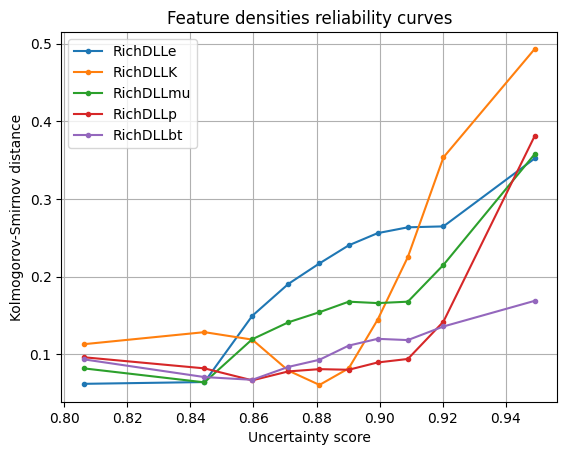

In [26]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

## Uncertainty heatmaps

### FD heatmaps

In [27]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

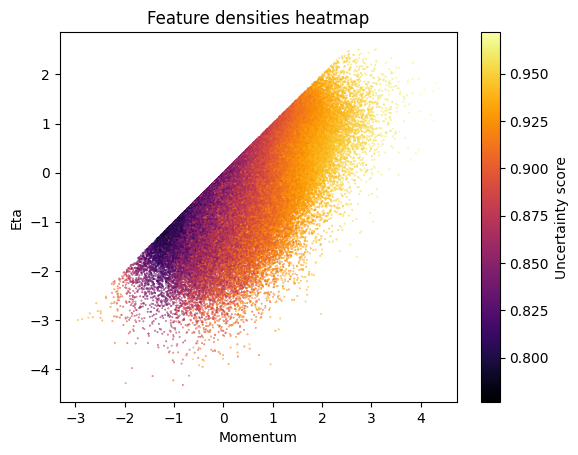

In [28]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [29]:
def uncertainty_hist2d_fd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
  momentum_indices = np.digitize(momentum, momentum_edges)
  eta_indices = np.digitize(eta, eta_edges)

  heatmap = []

  for i in range(1, n_bins + 1):
    row = []
    for j in range(1, n_bins + 1):
      row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
    heatmap += [row]

  plt.title('Feature densities heatmap')
  plt.imshow(heatmap, 'inferno')
  plt.gca().invert_yaxis()
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

/tmp/ipykernel_962/927889820.py:16: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
/home/esteban/.virtualenvs/cern/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


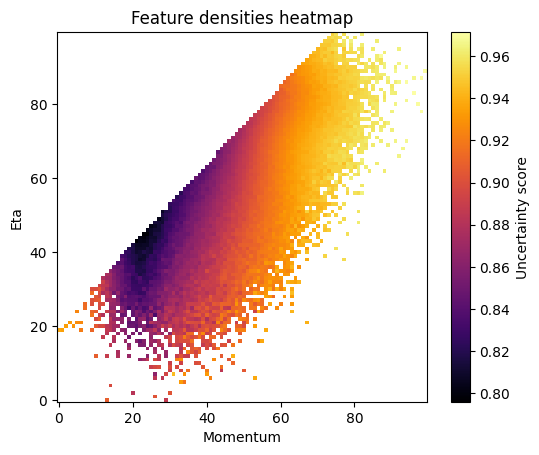

In [30]:
uncertainty_hist2d_fd(x_sample, fd_uncertainty_normalized)

In [31]:
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

def uncertainty_binned2d_fd(x_real, uncertainties, n_bins=5, bin_size=50):

    if not isinstance(x_real, np.ndarray):
        x_real = x_real.numpy()

    if not isinstance(uncertainties, np.ndarray):
        uncertainties = uncertainties.numpy()

    momentum = x_real[:, 0]
    eta = x_real[:, 1]
    num_tracks = x_real[:, 2]

    bin_edges = np.quantile(num_tracks, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(num_tracks, bin_edges, right=True)

    fig, axes = plt.subplots(1, n_bins, figsize=(16, 3))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(n_bins):
        mask = bin_indices == (i + 1)

        x_data = momentum[mask]
        y_data = eta[mask]
        u_data = uncertainties[mask]

        x_bins = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), bin_size)
        y_bins = np.linspace(y_data.min(), y_data.max(), bin_size)

        bin_means, x_edges, y_edges, _ = binned_statistic_2d(
            x_data, y_data, u_data, statistic='mean', bins=[x_bins, y_bins]
        )

        ax = axes[i]
        ax.set_title(f'Tracks [{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]')
        mesh = ax.pcolormesh(x_edges, y_edges, bin_means.T, cmap='inferno', shading='auto')
        ax.set_xscale('log')
        ax.set_xlabel('Momentum')
        ax.set_ylabel('Eta')

    fig.colorbar(mesh, ax=axes, label='Uncertainty score', orientation='vertical', fraction=0.02, pad=0.01)
    plt.suptitle('Features Densities Heatmap for Different Track Ranges', y=1.05)
    plt.savefig("Features_densities_heatmap_for_different_track_ranges.svg", format="svg")
    plt.show()


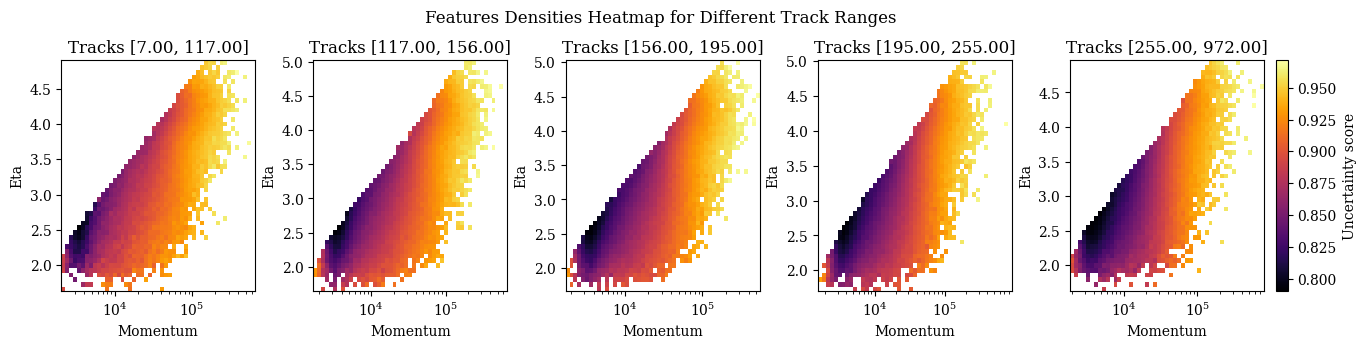

In [32]:
uncertainty_binned2d_fd(x_sample_orig, fd_uncertainty_normalized)

# Efficiency plots

In [33]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

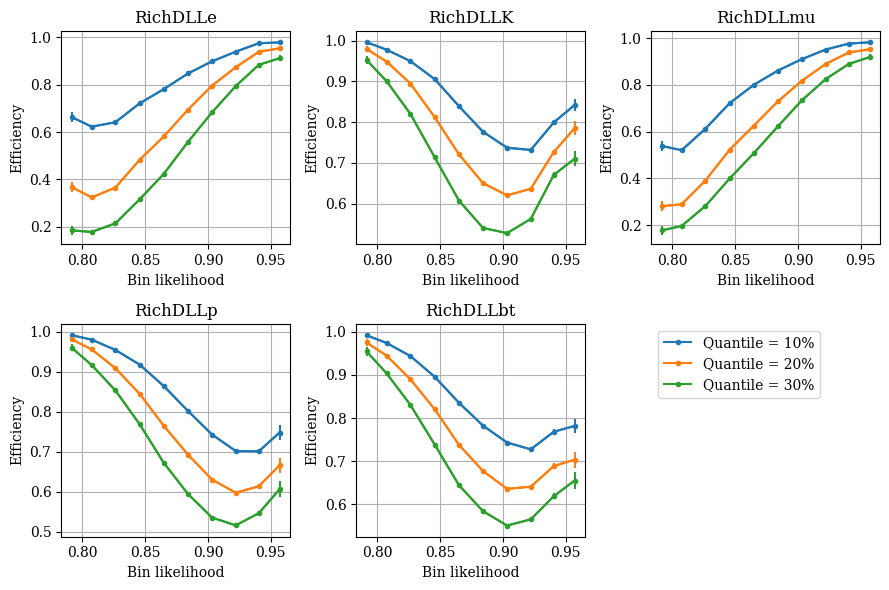

In [34]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

## Plot Efficiencies by particle

In [35]:
def plot_efficiencies_by_particle(y_sample, t_generated, uncertainties, quantiles, uncertainty_type="MCD", particle_idx=0, n_bins=10, dll_columns=DLL_COLUMNS):
    y_sample = np.array(y_sample)
    t_generated = np.array(t_generated)
    uncertainties = np.array(uncertainties)

    fig, axes = plt.subplots(2, 3, figsize=(9, 6))

    colors = plt.colormaps['tab10']

    if uncertainty_type == "MCD":
        uncertainties_column = uncertainties[:, particle_idx]
    else:
        uncertainties_column = uncertainties


    bin_edges = np.quantile(uncertainties_column, np.linspace(0, 1, n_bins + 1))
    indices = np.digitize(uncertainties_column, bin_edges, right=True)

    bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
    bins_real = [y_sample[indices == i] for i in range(1, n_bins + 1)]
    bins_likelihoods = [uncertainties_column[indices == i].mean() for i in range(1, n_bins + 1)]

    for idx, ax in zip(range(len(quantiles)), axes.flatten()):
        quantile = quantiles[idx]
        threshold = select_threshold(y_sample[:, particle_idx], quantile)

        eff_gen, err_gen = efficiency_bins(bins_targets, threshold, particle_idx)
        eff_real, err_real = efficiency_bins(bins_real, threshold, particle_idx)



        ax.plot(bins_likelihoods, eff_gen, '.-', color=colors(0), label='Generated')

        ax.fill_between(bins_likelihoods, np.array(eff_gen) - np.array(err_gen),
                        np.array(eff_gen) + np.array(err_gen), color=colors(0), alpha=0.3)

        ax.plot(bins_likelihoods, eff_real, '.-', color=colors(20), label='Real')

        ax.fill_between(bins_likelihoods, np.array(eff_real) - np.array(err_real),
                        np.array(eff_real) + np.array(err_real), color=colors(20), alpha=0.3)

        ax.set_title(f'Threshold {int(quantile * 100)}%')
        ax.set_axisbelow(True)
        ax.grid()
        ax.set_xlabel("Uncertainty Score")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1.10)

    axes[-1, -1].axis(False)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.73, 0.45), fontsize='small')

    plt.suptitle(f'{uncertainty_type} efficiencies plot for {dll_columns[particle_idx]}')

    plt.tight_layout()
    plt.show()

### Plot FD efficiencies

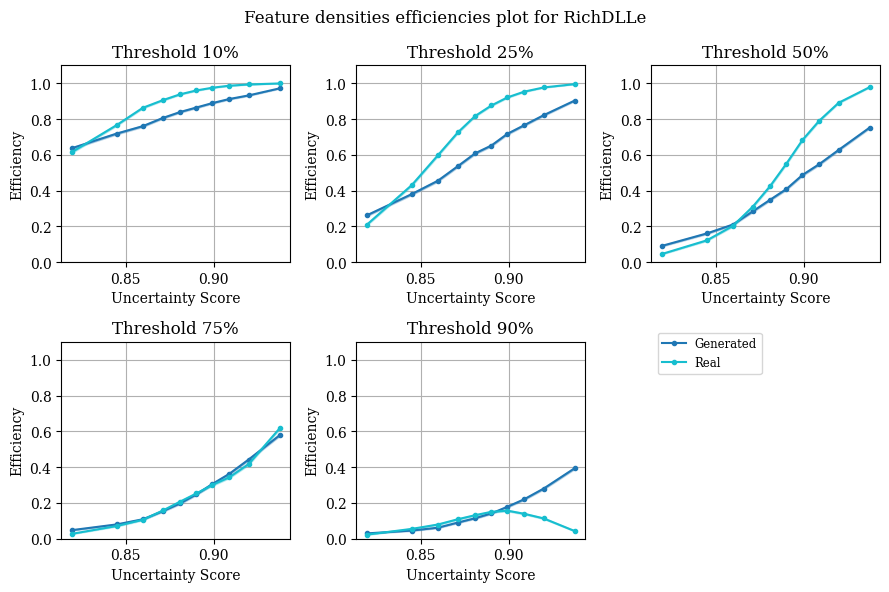

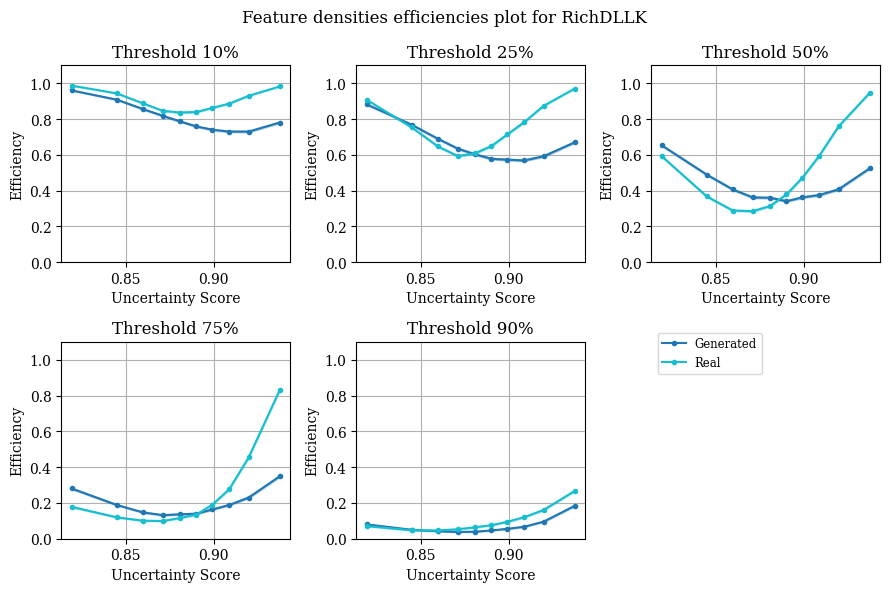

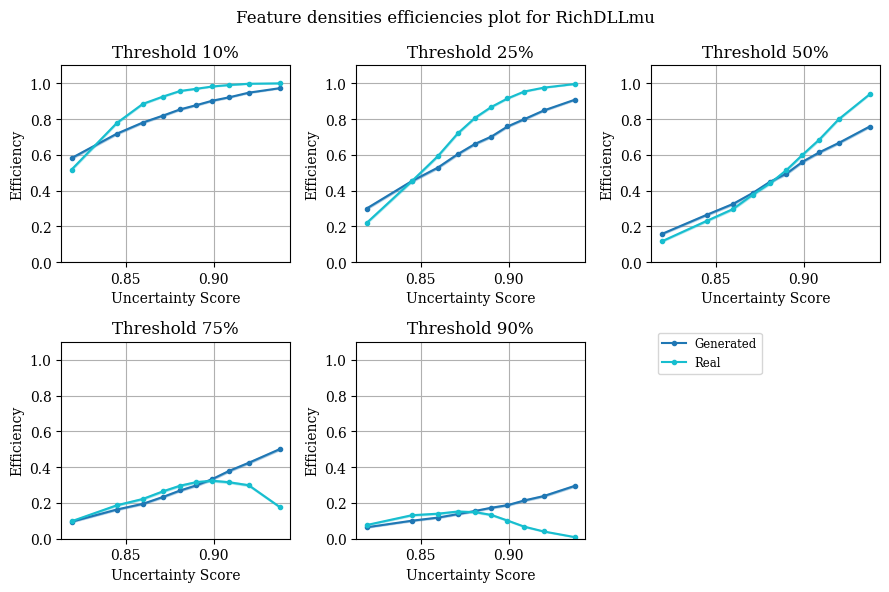

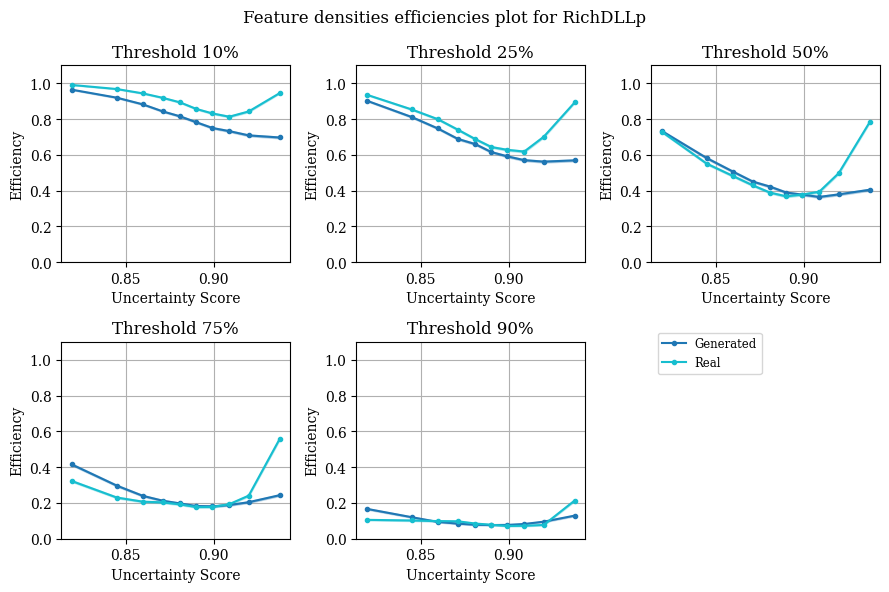

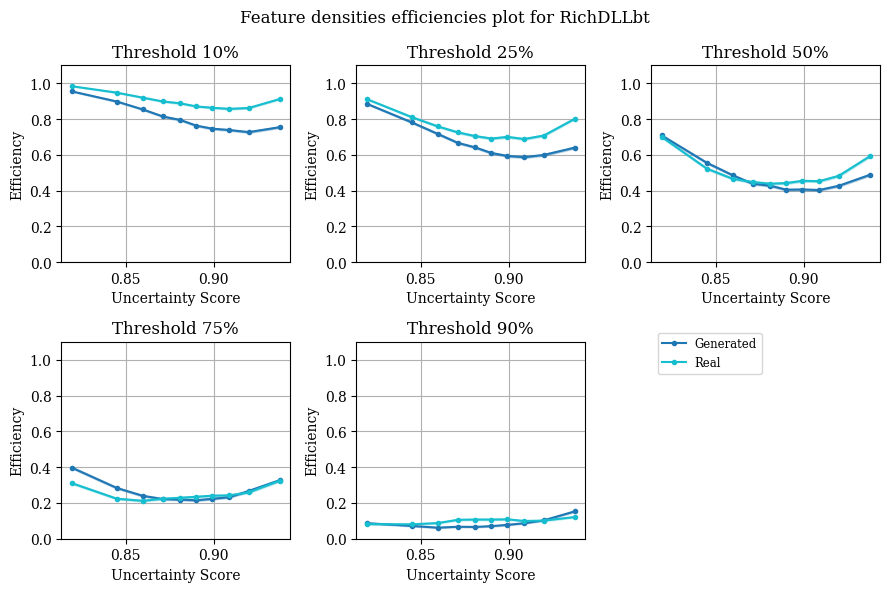

In [36]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, fd_uncertainty_normalized, [.1, .25, .5, .75, .9], "Feature densities", i)

#### MCD / Linear bins

In [37]:
all_mcd_bin_edges, all_mcd_js_distances = [], []


for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

NameError: name 'mcd_uncertainty' is not defined

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

#### FD / Linear bins

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')